# Redfin Market Data

This notebook contains scripts that download housing market data from the Redfin and combine it with the geographical and population data from the U.S. Census Bureau. The resulting dataset has the following structure:

* `geo_id` - a unique identifier of the place in Census Bureau format.
* `place` - a name of the geographical place (e.g. city or town).
* `place_lsad` - a name of the geographical place with its LSAD type.
* `state_abbr` - two-symbol USPS state abbreviation.
* `place_state` - a name of the place, including state abbreviation.
* `property_type` - a type of the property (`CONDO`, `APARTMENT`, `HOUSE` or `TOWNHOUSE`).
* `median_sale_price` - median sale price among properties of a particular type.
* `median_sale_price_mom` - month-over-month change of the median sale price.
* `median_sale_price_yoy` - year-over-year change of the median sale price.
* `median_list_price` - median list price among properties of a particular type.
* `median_list_price_mom` - month-over-month change of the median list price.
* `median_list_price_yoy` - year-over-year change of the median list price.
* `median_downpayment_5` - median mortgage downpayment of 5% in USD among properties of a particular type.
* `median_downpayment_10` - median mortgage downpayment of 10% in USD among properties of a particular type.
* `median_downpayment_15` - median mortgage downpayment of 15% in USD among properties of a particular type.
* `median_downpayment_20` - median mortgage downpayment of 20% in USD among properties of a particular type.
* `median_mortgage_5` - median mortgage loan amount in USD with 5% downpayment among properties of a particular type.
* `median_mortgage_10` - median mortgage loan amount in USD with 10% downpayment among properties of a particular type.
* `median_mortgage_15` - median mortgage loan amount in USD with 15% downpayment among properties of a particular type.
* `median_mortgage_20` - median mortgage loan amount in USD with 20% downpayment among properties of a particular type.
* `median_payment_30_5` - median monthly payment for 30 years mortgage with 5% downpayment amomng properties of a particular type.
* `median_payment_30_10` - median monthly payment for 30 years mortgage with 10% downpayment amomng properties of a particular type.
* `median_payment_30_15` - median monthly payment for 30 years mortgage with 15% downpayment amomng properties of a particular type.
* `median_payment_30_20` - median monthly payment for 30 years mortgage with 20% downpayment amomng properties of a particular type.
* `median_payment_15_5` - median monthly payment for 15 years mortgage with 5% downpayment amomng properties of a particular type.
* `median_payment_15_10` - median monthly payment for 15 years mortgage with 10% downpayment amomng properties of a particular type.
* `median_payment_15_15` - median monthly payment for 15 years mortgage with 15% downpayment amomng properties of a particular type.
* `median_payment_15_20` - median monthly payment for 15 years mortgage with 20% downpayment amomng properties of a particular type.
* `median_payment_10_5` - median monthly payment for 10 years mortgage with 5% downpayment amomng properties of a particular type.
* `median_payment_10_10` - median monthly payment for 10 years mortgage with 10% downpayment amomng properties of a particular type.
* `median_payment_10_15` - median monthly payment for 10 years mortgage with 15% downpayment amomng properties of a particular type.
* `median_payment_10_20` - median monthly payment for 10 years mortgage with 20% downpayment amomng properties of a particular type.
* `homes_sold` - the number of homes of a particular type sold during the period.
* `pending_sales` - the number of homes of a particular type pending sale during the period.
* `new_listings` - the number of homes of a particular type went on sale during the period.
* `inventory` - the number of homes of a particular type on sale during the period.
* `median_dom` - the median number of days while homes of a particular type were on market.
* `avg_sale_to_list` - average ratio between sale price and list price for homes of a particular type.
* `sold_above_list` - the percentage of homes of a particular type sold above their list price.
* `price_drops` - the percentage of homes of a particular type sold below their list price.
* `pop_prev` - the population of the place, according to the previous census survey.
* `pop_last` - the population of the place, according to the latest census survey.
* `pop_est` - the current estimated place population.
* `pop_dod` - decade-over-decade population change (between previous and the latest census surveys).
* `pop_ltd` - last-to-date population change (between the latest census survey and current estimate).
* `lat` - the geographical latitude of the place.
* `lon` - the geographical longitude of the place.

The mortgage rates used to calculate monthly payments are defined in the dictionary `MORTGAGE_RATE`. PMI rate is defined in the constant `PMI_RATE`.

The script generates the dataset in CSV format. Result file is stored in the output directory, specified by the `OUTBOUND_PATH` constant.

In [1]:
'''
Notebook parameters.
'''

DOWNLOAD = False
GEODATA_YEAR = "2022"
REDFIN_DATA_URI = "https://redfin-public-data.s3.us-west-2.amazonaws.com/redfin_market_tracker"
GEODATA_BASE_URI = "https://www2.census.gov/geo/tiger"

DATA_PATH = "../data"
INBOUND_PATH = DATA_PATH + "/inbound/redfin"
OUTBOUND_PATH = DATA_PATH + "/outbound/housing"

In [2]:
'''
Define U.S. regions.
'''

NEW_ENGLAND         = ["CT", "ME", "MA", "NH", "RI", "VT"]
MIDDLE_ATLANTIC     = ["NJ", "NY", "PA"]
EAST_NORTH_CENTRAL  = ["IN", "IL", "MI", "OH", "WI"]
WEST_NORTH_CENTRAL  = ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]
SOUTH_ATLANTIC      = ["DE", "DC", "FL", "GA", "MD", "NC", "SC", "VA", "WV"]
EAST_SOUTH_CENTRAL  = ["AL", "KY", "MS", "TN"]
WEST_SOUTH_CENTRAL  = ["AR", "LA", "OK", "TX"]
MOUNTAIN            = ["AZ", "CO", "ID", "NM", "MT", "UT", "NV", "WY"]
PACIFIC             = ["CA", "OR", "WA"]
OCEAN               = ["AK", "HI"]

NORTHEAST           = NEW_ENGLAND + MIDDLE_ATLANTIC
MIDWEST             = EAST_NORTH_CENTRAL + WEST_NORTH_CENTRAL
SOUTH               = SOUTH_ATLANTIC + EAST_SOUTH_CENTRAL + WEST_SOUTH_CENTRAL
WEST                = MOUNTAIN + PACIFIC
CONTINENTAL         = NORTHEAST + MIDWEST + SOUTH + WEST

In [3]:
'''
Property types map.
'''

PROPERTY_TYPES = {
    -1: "ALL",
    3: "CONDO",
    4: "APARTMENT",
    6: "HOUSE",
    13: "TOWNHOUSE"
}


In [4]:
'''
Average national mortgage rates
'''

MORTGAGE_RATE = {
    30: 0.0684,
    15: 0.0622,
    10: 0.0635,
}

PMI_RATE = 0.0058

In [5]:
'''
Import dependencies.
'''

import os
import wget
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from pandas.api.types import CategoricalDtype

In [6]:
'''
Load U.S. cities and towns dataset.
'''

places = pd.read_csv(
    "../data/outbound/geo/us_places.csv.gz",
    dtype={
        "geo_id": "string",
        "name": "string",
        "lsad_code": "string",
        "name_lsad": "string",
        "state_abbr": "string",
        "name_state": "string",
        "status": "string",
        "area_land": "int64",
        "area_water": "int64",
        "area_total": "int64",
        "lat": "float64",
        "lon": "float64",
        "pop_prev": "Int64",
        "pop_last": "Int64",
        "pop_est": "Int64",
        "pop_dod": "float64",
        "pop_ltd": "float64",
    },
    compression="gzip",
)

# rename columns
places.rename(
    columns={
        "name_lsad": "place_lsad",
        "name_state": "place_state",
    },
    inplace=True,
)

# we make a copy of the dataset with townships only to handle 
# special cases later
townships = places[places.lsad_code == "44"].copy()

places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69074 entries, 0 to 69073
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geo_id       69074 non-null  string 
 1   name         69074 non-null  string 
 2   lsad_code    69074 non-null  string 
 3   place_lsad   69074 non-null  string 
 4   state_abbr   69074 non-null  string 
 5   place_state  69074 non-null  string 
 6   status       69074 non-null  string 
 7   area_land    69074 non-null  int64  
 8   area_water   69074 non-null  int64  
 9   area_total   69074 non-null  int64  
 10  lat          69074 non-null  float64
 11  lon          69074 non-null  float64
 12  pop_prev     40352 non-null  Int64  
 13  pop_last     40375 non-null  Int64  
 14  pop_est      40375 non-null  Int64  
 15  pop_dod      40348 non-null  float64
 16  pop_ltd      40375 non-null  float64
dtypes: Int64(3), float64(4), int64(3), string(7)
memory usage: 9.2 MB


In [7]:
'''
Cleanup places with duplicated names and states.

Useful Links:

    * Functional status codes - https://www.census.gov/library/reference/code-lists/functional-status-codes.html
    * LSAD codes - https://www.census.gov/library/reference/code-lists/legal-status-codes.html

'''

# drop all numbered places
places.drop(
    places[places.name.isin([
        "1", "2", "3", "4", "5", "6", "7", "8", "9",
        "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", 
        "20", "21", "22", "23", "24", "25",
        "1A", "1B", "4A", "4B", "A",
    ])].index,
    inplace=True
)

# drop places with duplicated names, LSAD codes and statuses which have less population or land area
aux = places.sort_values(["pop_prev", "pop_last", "area_land", "area_total"], ascending=False)
places.drop(
    aux[aux[["place_state", "lsad_code", "status"]].duplicated()].index,
    inplace=True
)

# drop places with duplicated names and LSAD codes which have fictitious status
places.drop(
    places[places[["place_state", "lsad_code"]].duplicated(keep=False) & (places.status == "F")].index,
    inplace=True
)

# drop places with duplicated names and LSAD codes which have nonfunctioning status
places.drop(
    places[places[["place_state", "lsad_code"]].duplicated(keep=False) & (places.status == "N")].index,
    inplace=True
)

# drop places with duplicated names and LSAD codes which have inactive status
places.drop(
    places[places[["place_state", "lsad_code"]].duplicated(keep=False) & (places.status == "I")].index,
    inplace=True
)

# drop places with duplicated names and LSAD codes which are governmnet entities
places.drop(
    places[places[["place_state", "lsad_code"]].duplicated(keep=False) & (places.status == "C")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not cities but boroughs
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "21")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not CDP's but CCD's
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "22")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not CDP's but census subarea
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "23")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not purchase but grant
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "32")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not CDP's but UT
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "46")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not cities but charter townships
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "49")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not cities but townships
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places["lsad_code"] == "44")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not towns but villages
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "47")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not cities but towns
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "43")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not zona urbana but comunidad
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "55")].index,
    inplace=True
)

# drop places with duplicated names and statuses which are not barrio but barrio-pueblo
places.drop(
    places[places[["place_state", "status"]].duplicated(keep=False) & (places.lsad_code == "41")].index,
    inplace=True
)

# drop places with duplicated names which have nonfunctioning status
places.drop(
    places[places.place_state.duplicated(keep=False) & (places.status == "N")].index,
    inplace=True
)

# drop places with duplicated names which have inactive status
places.drop(
    places[places.place_state.duplicated(keep=False) & (places.status == "I")].index,
    inplace=True
)

# drop places with duplicated names which have fictitious status
places.drop(
    places[places.place_state.duplicated(keep=False) & (places.status == "F")].index,
    inplace=True
)

# drop places with duplicated names which are government entities
places.drop(
    places[places.place_state.duplicated(keep=False) & places.status.isin(["B", "C", "G"])].index,
    inplace=True
)

# drop places with duplicated names which are statistical entities
places.drop(
    places[places.place_state.duplicated(keep=False) & (places.status == "S")].index,
    inplace=True
)

# special case for Nashville, TN
places.loc[places.place_state == "Nashville-Davidson, TN", "name_state"] = "Nashville, TN"

places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47856 entries, 0 to 69073
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geo_id       47856 non-null  string 
 1   name         47856 non-null  string 
 2   lsad_code    47856 non-null  string 
 3   place_lsad   47856 non-null  string 
 4   state_abbr   47856 non-null  string 
 5   place_state  47856 non-null  string 
 6   status       47856 non-null  string 
 7   area_land    47856 non-null  int64  
 8   area_water   47856 non-null  int64  
 9   area_total   47856 non-null  int64  
 10  lat          47856 non-null  float64
 11  lon          47856 non-null  float64
 12  pop_prev     29793 non-null  Int64  
 13  pop_last     29812 non-null  Int64  
 14  pop_est      29812 non-null  Int64  
 15  pop_dod      29792 non-null  float64
 16  pop_ltd      29812 non-null  float64
 17  name_state   1 non-null      object 
dtypes: Int64(3), float64(4), int64(3), object(1), 

In [8]:
'''
Cleanup townships with duplicated names and states.
'''

# drop townships with duplicated names and statuses which have less population or land area
aux = townships.sort_values(["pop_prev", "pop_last", "area_land", "area_total"], ascending=False)
townships.drop(
    aux[aux[["place_state", "lsad_code", "status"]].duplicated()].index,
    inplace=True
)

# drop townships with duplicated names which have nonfunctioning status
townships.drop(
    townships[townships.place_state.duplicated(keep=False) & (townships.status == "N")].index,
    inplace=True
)

# drop townships with duplicated names which have inactive status
townships.drop(
    townships[townships.place_state.duplicated(keep=False) & (townships.status == "I")].index,
    inplace=True
)

# drop townships with duplicated names which are government entities
townships.drop(
    townships[townships.place_state.duplicated(keep=False) & (townships.status == "C")].index,
    inplace=True
)

townships.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12826 entries, 33008 to 68985
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geo_id       12826 non-null  string 
 1   name         12826 non-null  string 
 2   lsad_code    12826 non-null  string 
 3   place_lsad   12826 non-null  string 
 4   state_abbr   12826 non-null  string 
 5   place_state  12826 non-null  string 
 6   status       12826 non-null  string 
 7   area_land    12826 non-null  int64  
 8   area_water   12826 non-null  int64  
 9   area_total   12826 non-null  int64  
 10  lat          12826 non-null  float64
 11  lon          12826 non-null  float64
 12  pop_prev     9636 non-null   Int64  
 13  pop_last     9637 non-null   Int64  
 14  pop_est      9637 non-null   Int64  
 15  pop_dod      9636 non-null   float64
 16  pop_ltd      9637 non-null   float64
dtypes: Int64(3), float64(4), int64(3), string(7)
memory usage: 1.8 MB


In [9]:
'''
Update full names of all townships.
'''

townships.place_state = townships.name + " Township, " + townships.state_abbr
townships.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12826 entries, 33008 to 68985
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geo_id       12826 non-null  string 
 1   name         12826 non-null  string 
 2   lsad_code    12826 non-null  string 
 3   place_lsad   12826 non-null  string 
 4   state_abbr   12826 non-null  string 
 5   place_state  12826 non-null  string 
 6   status       12826 non-null  string 
 7   area_land    12826 non-null  int64  
 8   area_water   12826 non-null  int64  
 9   area_total   12826 non-null  int64  
 10  lat          12826 non-null  float64
 11  lon          12826 non-null  float64
 12  pop_prev     9636 non-null   Int64  
 13  pop_last     9637 non-null   Int64  
 14  pop_est      9637 non-null   Int64  
 15  pop_dod      9636 non-null   float64
 16  pop_ltd      9637 non-null   float64
dtypes: Int64(3), float64(4), int64(3), string(7)
memory usage: 1.8 MB


In [10]:
'''
Concatenate places with townships.
'''

places = pd.concat([places, townships])
places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60682 entries, 0 to 68985
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geo_id       60682 non-null  string 
 1   name         60682 non-null  string 
 2   lsad_code    60682 non-null  string 
 3   place_lsad   60682 non-null  string 
 4   state_abbr   60682 non-null  string 
 5   place_state  60682 non-null  string 
 6   status       60682 non-null  string 
 7   area_land    60682 non-null  int64  
 8   area_water   60682 non-null  int64  
 9   area_total   60682 non-null  int64  
 10  lat          60682 non-null  float64
 11  lon          60682 non-null  float64
 12  pop_prev     39429 non-null  Int64  
 13  pop_last     39449 non-null  Int64  
 14  pop_est      39449 non-null  Int64  
 15  pop_dod      39428 non-null  float64
 16  pop_ltd      39449 non-null  float64
 17  name_state   1 non-null      object 
dtypes: Int64(3), float64(4), int64(3), object(1), 

In [11]:
'''
Downlaod Redfin raw housing data.
'''

filename = "city_market_tracker.tsv000.gz"

if DOWNLOAD:
    # download dataset
    source = REDFIN_DATA_URI + "/" + filename
    dest = INBOUND_PATH + "/" + filename
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)

# create dataframe
redfin = pd.read_csv(
    INBOUND_PATH + "/" + filename, 
    compression="gzip", sep="\t",
    dtype={
        "region": "string",
        "city": "string",
        "state_code": "string",
        "property_type_id": "int16",
        "median_sale_price": "float64",
        "median_sale_price_mom": "float64",
        "median_sale_price_yoy": "float64",
        "median_list_price": "float64",
        "median_list_price_mom": "float64",
        "median_list_price_yoy": "float64",
        "homes_sold": "Int64",
        "pending_sales": "Int64",
        "new_listings": "Int64",
        "inventory": "Int64",
        "median_dom": "Int64",
        "avg_sale_to_list": "float64",
        "sold_above_list": "float64",
        "price_drops": "float64",
    },
)

# rename columns
redfin.rename(
    columns={
        "region": "place_state",
        "city": "place",
        "state_code": "state_abbr",
    },
    inplace=True,
)

# cleanup historical data
period_begin = redfin.period_begin.max()
period_end = redfin.period_end.max()
redfin = redfin[redfin.period_begin == period_begin]

# normalize city names
redfin.place_state = redfin.place_state.str.replace("&", "and")
redfin.place = redfin.place.str.replace("&", "and")

# normalize property types
redfin.property_type = redfin.property_type_id.apply(lambda x: PROPERTY_TYPES[x]).astype(CategoricalDtype(ordered=False))

# drop unnecessary columns
redfin.drop(
    [
        "period_begin", "period_end", "period_duration",
        "region_type", "region_type_id", "table_id",
        "is_seasonally_adjusted", "state", "property_type_id",
        "median_ppsf", "median_ppsf_mom", "median_ppsf_yoy", 
        "median_list_ppsf", "median_list_ppsf_mom", "median_list_ppsf_yoy",
        "homes_sold_mom", "homes_sold_yoy",
        "pending_sales_mom", "pending_sales_yoy",
        "new_listings_mom", "new_listings_yoy",
        "inventory_mom", "inventory_yoy",
        "months_of_supply", "months_of_supply_mom", "months_of_supply_yoy",
        "median_dom_mom", "median_dom_yoy",
        "avg_sale_to_list_mom", "avg_sale_to_list_yoy", 
        "sold_above_list_mom", "sold_above_list_yoy",
        "price_drops_mom", "price_drops_yoy",
        "off_market_in_two_weeks", "off_market_in_two_weeks_mom", "off_market_in_two_weeks_yoy",
        "parent_metro_region", "parent_metro_region_metro_code", "last_updated"
    ],
    axis=1,
    inplace=True
)

redfin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38696 entries, 48 to 4600783
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   place_state            38696 non-null  string  
 1   place                  38696 non-null  string  
 2   state_abbr             38696 non-null  string  
 3   property_type          38696 non-null  category
 4   median_sale_price      38696 non-null  float64 
 5   median_sale_price_mom  32811 non-null  float64 
 6   median_sale_price_yoy  32758 non-null  float64 
 7   median_list_price      32444 non-null  float64 
 8   median_list_price_mom  28474 non-null  float64 
 9   median_list_price_yoy  28038 non-null  float64 
 10  homes_sold             38696 non-null  Int64   
 11  pending_sales          32674 non-null  Int64   
 12  new_listings           32448 non-null  Int64   
 13  inventory              35671 non-null  Int64   
 14  median_dom             38406 non-nu

In [12]:
'''
Merge Redfin dataset with geographical data.
'''

redfin = pd.merge(
    redfin,
    places[[
        "geo_id", "place_lsad", "place_state",
        "state_abbr", "lat", "lon",
        "pop_last", "pop_prev", "pop_est",
        "pop_dod", "pop_ltd",
    ]],
    on=["place_state", "state_abbr"],
    how="left"
)

redfin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38696 entries, 0 to 38695
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   place_state            38696 non-null  string  
 1   place                  38696 non-null  string  
 2   state_abbr             38696 non-null  string  
 3   property_type          38696 non-null  category
 4   median_sale_price      38696 non-null  float64 
 5   median_sale_price_mom  32811 non-null  float64 
 6   median_sale_price_yoy  32758 non-null  float64 
 7   median_list_price      32444 non-null  float64 
 8   median_list_price_mom  28474 non-null  float64 
 9   median_list_price_yoy  28038 non-null  float64 
 10  homes_sold             38696 non-null  Int64   
 11  pending_sales          32674 non-null  Int64   
 12  new_listings           32448 non-null  Int64   
 13  inventory              35671 non-null  Int64   
 14  median_dom             38406 non-null 

In [13]:
'''
Calculate additional data
'''

# calculate downpayments
redfin["median_downpayment_5"] = np.round(redfin.median_list_price * 0.05)
redfin["median_downpayment_10"] = np.round(redfin.median_list_price * 0.1)
redfin["median_downpayment_15"] = np.round(redfin.median_list_price * 0.15)
redfin["median_downpayment_20"] = np.round(redfin.median_list_price * 0.2)

# calculate mortgages
redfin["median_mortgage_5"] = np.round(redfin.median_list_price * 0.95)
redfin["median_mortgage_10"] = np.round(redfin.median_list_price * 0.9)
redfin["median_mortgage_15"] = np.round(redfin.median_list_price * 0.85)
redfin["median_mortgage_20"] = np.round(redfin.median_list_price * 0.8)

# calculate monthly payment

def mortgage_monthly_payment(mortgage, period, pmi = False):
    '''
    Calculates mortgage monthly payment. 
    '''
    monthly_rate = MORTGAGE_RATE[period] / 12
    aux = (1 + monthly_rate)**(period * 12)
    payment = mortgage * ((monthly_rate * aux) / (aux - 1))
    if pmi:
        payment += (mortgage * PMI_RATE) / 12
    return np.round(payment)

redfin["median_payment_30_5"] = mortgage_monthly_payment(redfin.median_mortgage_5, 30, True)
redfin["median_payment_30_10"] = mortgage_monthly_payment(redfin.median_mortgage_10, 30, True)
redfin["median_payment_30_15"] = mortgage_monthly_payment(redfin.median_mortgage_15, 30, True)
redfin["median_payment_30_20"] = mortgage_monthly_payment(redfin.median_mortgage_20, 30)

redfin["median_payment_15_5"] = mortgage_monthly_payment(redfin.median_mortgage_5, 15, True)
redfin["median_payment_15_10"] = mortgage_monthly_payment(redfin.median_mortgage_10, 15, True)
redfin["median_payment_15_15"] = mortgage_monthly_payment(redfin.median_mortgage_15, 15, True)
redfin["median_payment_15_20"] = mortgage_monthly_payment(redfin.median_mortgage_20, 15)

redfin["median_payment_10_5"] = mortgage_monthly_payment(redfin.median_mortgage_5, 10, True)
redfin["median_payment_10_10"] = mortgage_monthly_payment(redfin.median_mortgage_10, 10, True)
redfin["median_payment_10_15"] = mortgage_monthly_payment(redfin.median_mortgage_15, 10, True)
redfin["median_payment_10_20"] = mortgage_monthly_payment(redfin.median_mortgage_20, 10)

redfin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38696 entries, 0 to 38695
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   place_state            38696 non-null  string  
 1   place                  38696 non-null  string  
 2   state_abbr             38696 non-null  string  
 3   property_type          38696 non-null  category
 4   median_sale_price      38696 non-null  float64 
 5   median_sale_price_mom  32811 non-null  float64 
 6   median_sale_price_yoy  32758 non-null  float64 
 7   median_list_price      32444 non-null  float64 
 8   median_list_price_mom  28474 non-null  float64 
 9   median_list_price_yoy  28038 non-null  float64 
 10  homes_sold             38696 non-null  Int64   
 11  pending_sales          32674 non-null  Int64   
 12  new_listings           32448 non-null  Int64   
 13  inventory              35671 non-null  Int64   
 14  median_dom             38406 non-null 

In [14]:
'''
Rearrange columns.
'''

redfin = redfin[[
    "geo_id",
    "place",
    "place_lsad",
    "state_abbr",
    "place_state",
    "property_type",
    "median_sale_price",
    "median_sale_price_mom",
    "median_sale_price_yoy",
    "median_list_price",
    "median_list_price_mom",
    "median_list_price_yoy",
    "median_downpayment_5",
    "median_downpayment_10",
    "median_downpayment_15",
    "median_downpayment_20",
    "median_mortgage_5",
    "median_mortgage_10",
    "median_mortgage_15",
    "median_mortgage_20",
    "median_payment_30_5",
    "median_payment_30_10",
    "median_payment_30_15",
    "median_payment_30_20",
    "median_payment_15_5",
    "median_payment_15_10",
    "median_payment_15_15",
    "median_payment_15_20",
    "median_payment_10_5",
    "median_payment_10_10",
    "median_payment_10_15",
    "median_payment_10_20",
    "homes_sold",
    "pending_sales",
    "new_listings",
    "inventory",
    "median_dom",
    "avg_sale_to_list",
    "sold_above_list",
    "price_drops",
    "pop_prev",
    "pop_last",
    "pop_est",
    "pop_dod",
    "pop_ltd",
    "lat",
    "lon",
]]

print("Redfin data for period from {} to {}".format(period_begin, period_end))
redfin.info()

Redfin data for period from 2022-10-01 to 2022-10-31
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38696 entries, 0 to 38695
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   geo_id                 38052 non-null  string  
 1   place                  38696 non-null  string  
 2   place_lsad             38052 non-null  string  
 3   state_abbr             38696 non-null  string  
 4   place_state            38696 non-null  string  
 5   property_type          38696 non-null  category
 6   median_sale_price      38696 non-null  float64 
 7   median_sale_price_mom  32811 non-null  float64 
 8   median_sale_price_yoy  32758 non-null  float64 
 9   median_list_price      32444 non-null  float64 
 10  median_list_price_mom  28474 non-null  float64 
 11  median_list_price_yoy  28038 non-null  float64 
 12  median_downpayment_5   32444 non-null  float64 
 13  median_downpayment_10  32444 non-null 

In [15]:
redfin.head()

,geo_id,place,place_lsad,state_abbr,place_state,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,...,avg_sale_to_list,sold_above_list,price_drops,pop_prev,pop_last,pop_est,pop_dod,pop_ltd,lat,lon
0,1271100,Tangerine,Tangerine CDP,FL,"Tangerine, FL",HOUSE,410000.0,0.148459,0.073495,405000.0,...,0.980312,0.000000,0.333333,<NA>,<NA>,<NA>,NaN,NaN,28.760166,-81.637975
1,0604478,Bayview,Bayview CDP,CA,"Bayview, CA",HOUSE,730000.0,0.057971,-0.043877,757000.0,...,0.979471,0.500000,NaN,<NA>,<NA>,<NA>,NaN,NaN,40.765360,-124.178624
2,3946480,Madison,Madison village,OH,"Madison, OH",HOUSE,165750.0,-0.156489,-0.005997,199500.0,...,0.962004,0.357143,0.478261,3184,3433,3420,0.078204,-0.003787,41.772258,-81.052983
3,2167944,St. Matthews,St. Matthews city,KY,"St. Matthews, KY",ALL,282500.0,0.104851,0.162551,274000.0,...,0.965937,0.192308,0.303030,17437,17551,17437,0.006538,-0.006495,38.249334,-85.637758
4,4261048,Pittston,Pittston city,PA,"Pittston, PA",ALL,67450.0,-0.506132,-0.462550,169900.0,...,0.846154,0.000000,0.363636,7739,7579,7585,-0.020675,0.000792,41.327920,-75.785684


In [16]:
'''
Store in CSV format.
'''

redfin.to_csv(OUTBOUND_PATH + "/redfin.csv.gz", index=False, compression="gzip")

In [17]:
'''
Initialize states dataframe.
'''

# load dataframe
states = gpd.read_file(DATA_PATH + "/outbound/geo/us_states.shp.zip", compression="zip")

# normalize column types
states.fips_code = states.fips_code.astype("string")
states.usps_abbr = states.usps_abbr.astype("string")
states.name = states.name.astype("string")

states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   fips_code  56 non-null     string  
 1   usps_abbr  56 non-null     string  
 2   name       56 non-null     string  
 3   geometry   56 non-null     geometry
dtypes: geometry(1), string(3)
memory usage: 1.9 KB


<AxesSubplot: xlabel='lon', ylabel='lat'>

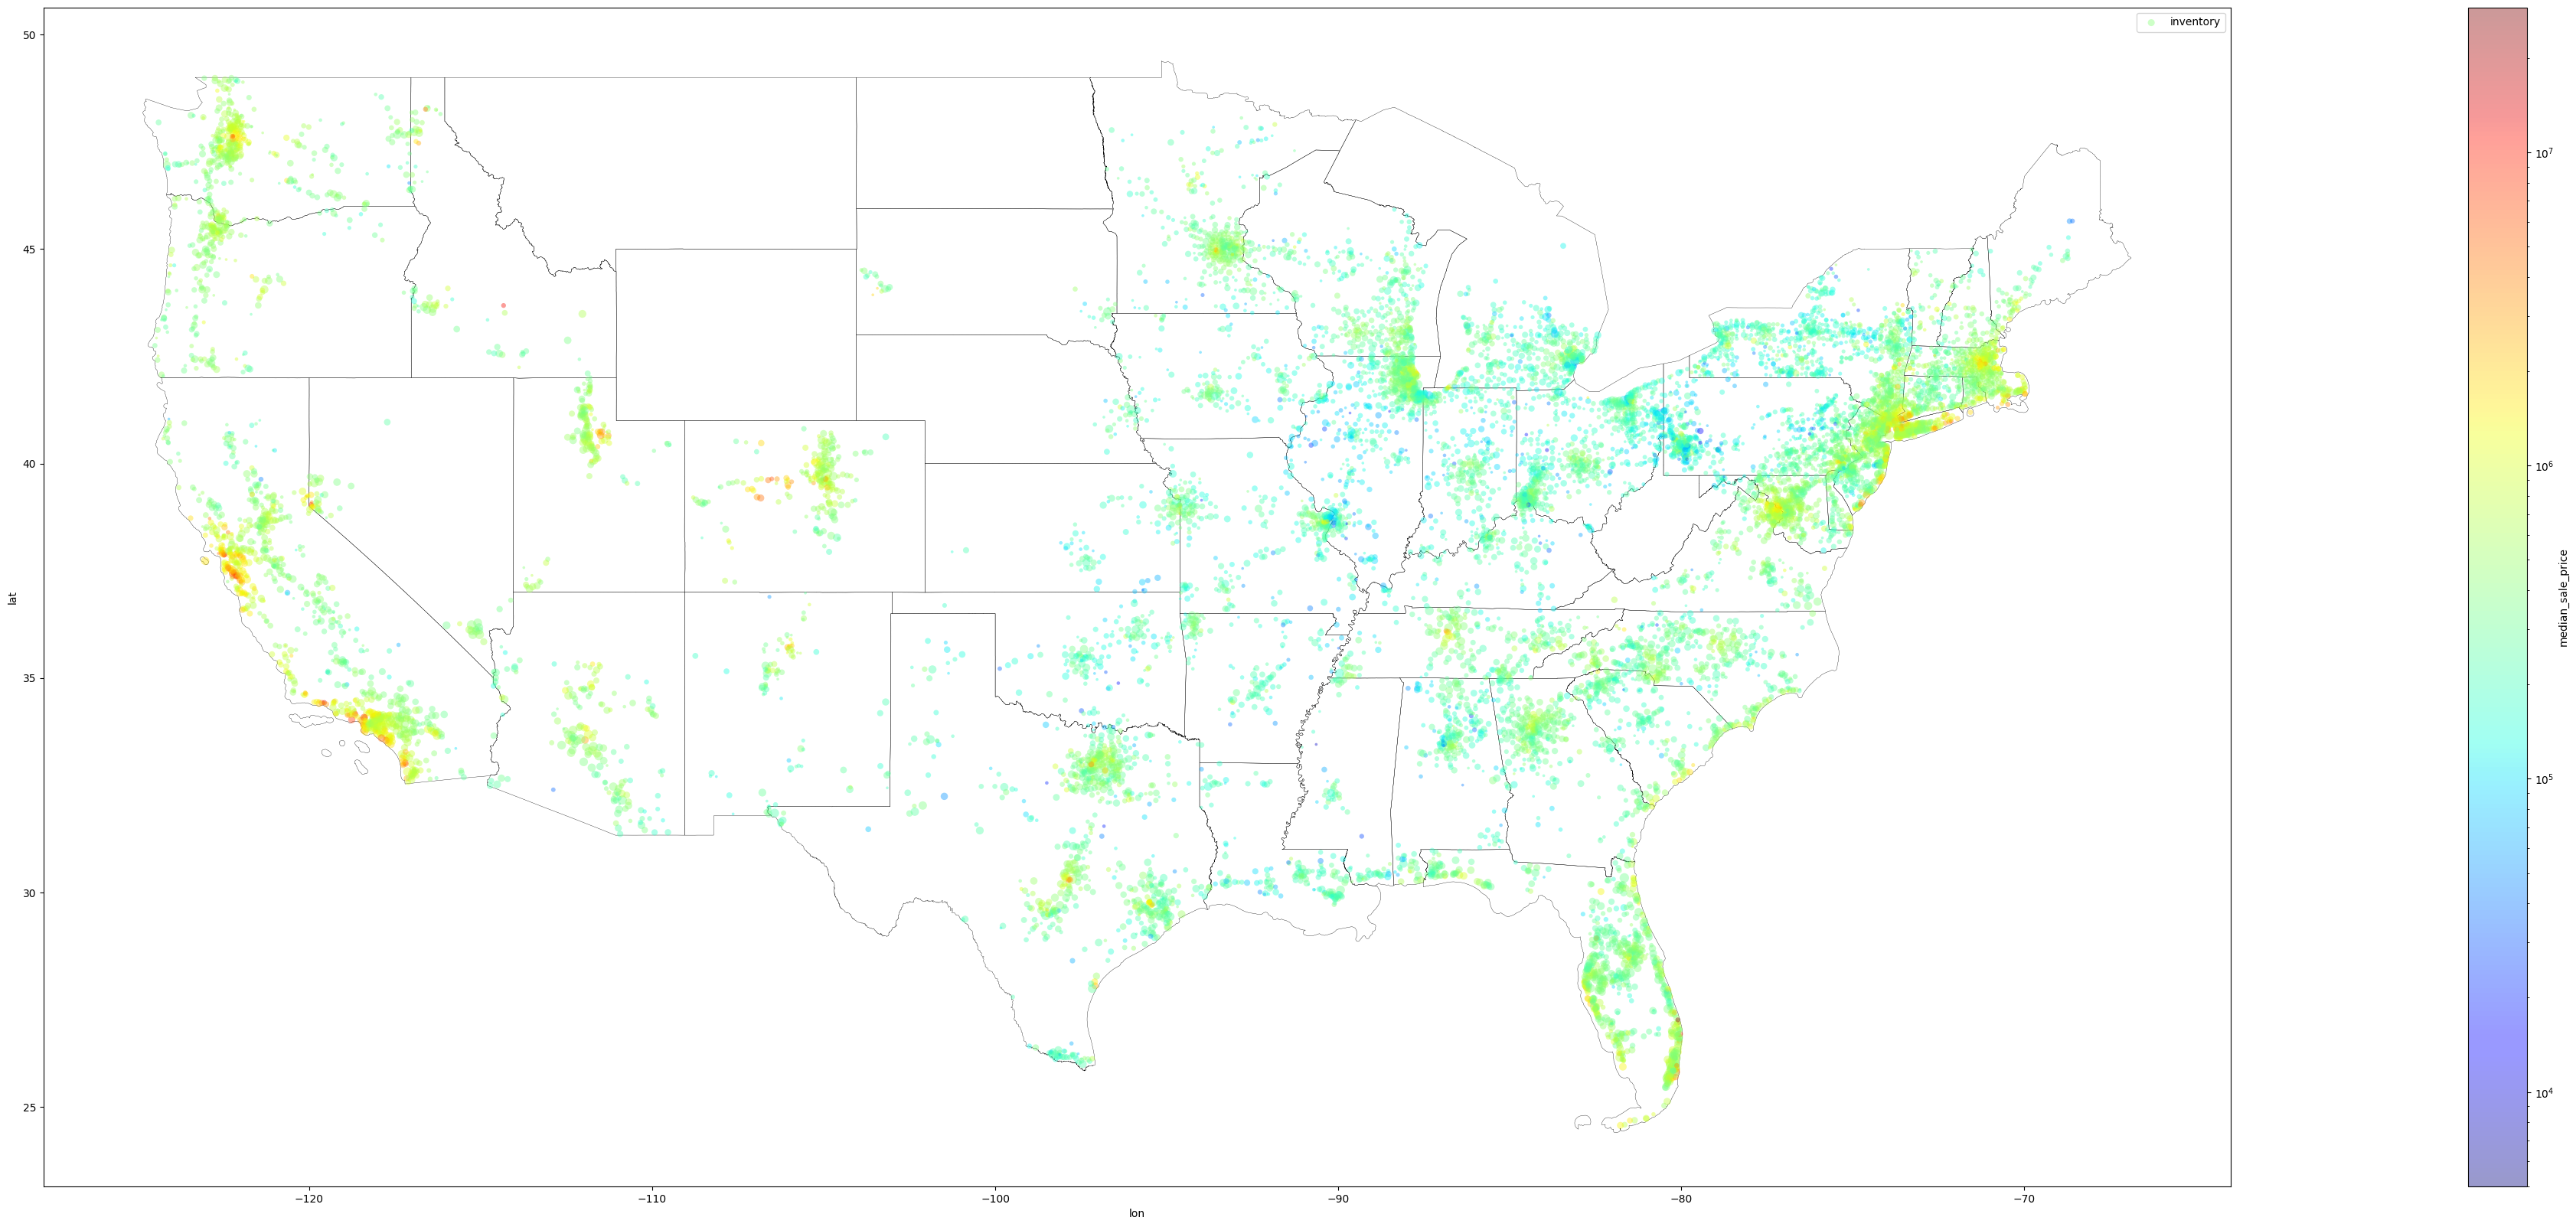

In [18]:
'''
Plot U.S. places on map.
'''
%matplotlib inline

REGION = CONTINENTAL

# take only continental part of the U.S.
states_map = states[states.usps_abbr.isin(REGION)]
redfin_map = redfin[(redfin.state_abbr.isin(REGION)) & (redfin.property_type == "HOUSE")]

fig = plt.figure(0, figsize=(80,20)) 
plot = fig.add_subplot()

states_map.boundary.plot(
    ax=plot, zorder=1,
    linewidth=0.25, color="black",
)

redfin_map.plot(
    ax=plot, zorder=2,
    kind="scatter", x="lon", y="lat", alpha=0.4, linewidths=0, plotnonfinite=True,
    s=np.log(redfin_map.inventory.astype("float64"))*10, label="inventory",
    c="median_sale_price", cmap="jet", colorbar=True,
    norm=colors.LogNorm(),
#     norm=colors.SymLogNorm(linthresh=0.01, vmin=-100, vmax=100, base=10),
)


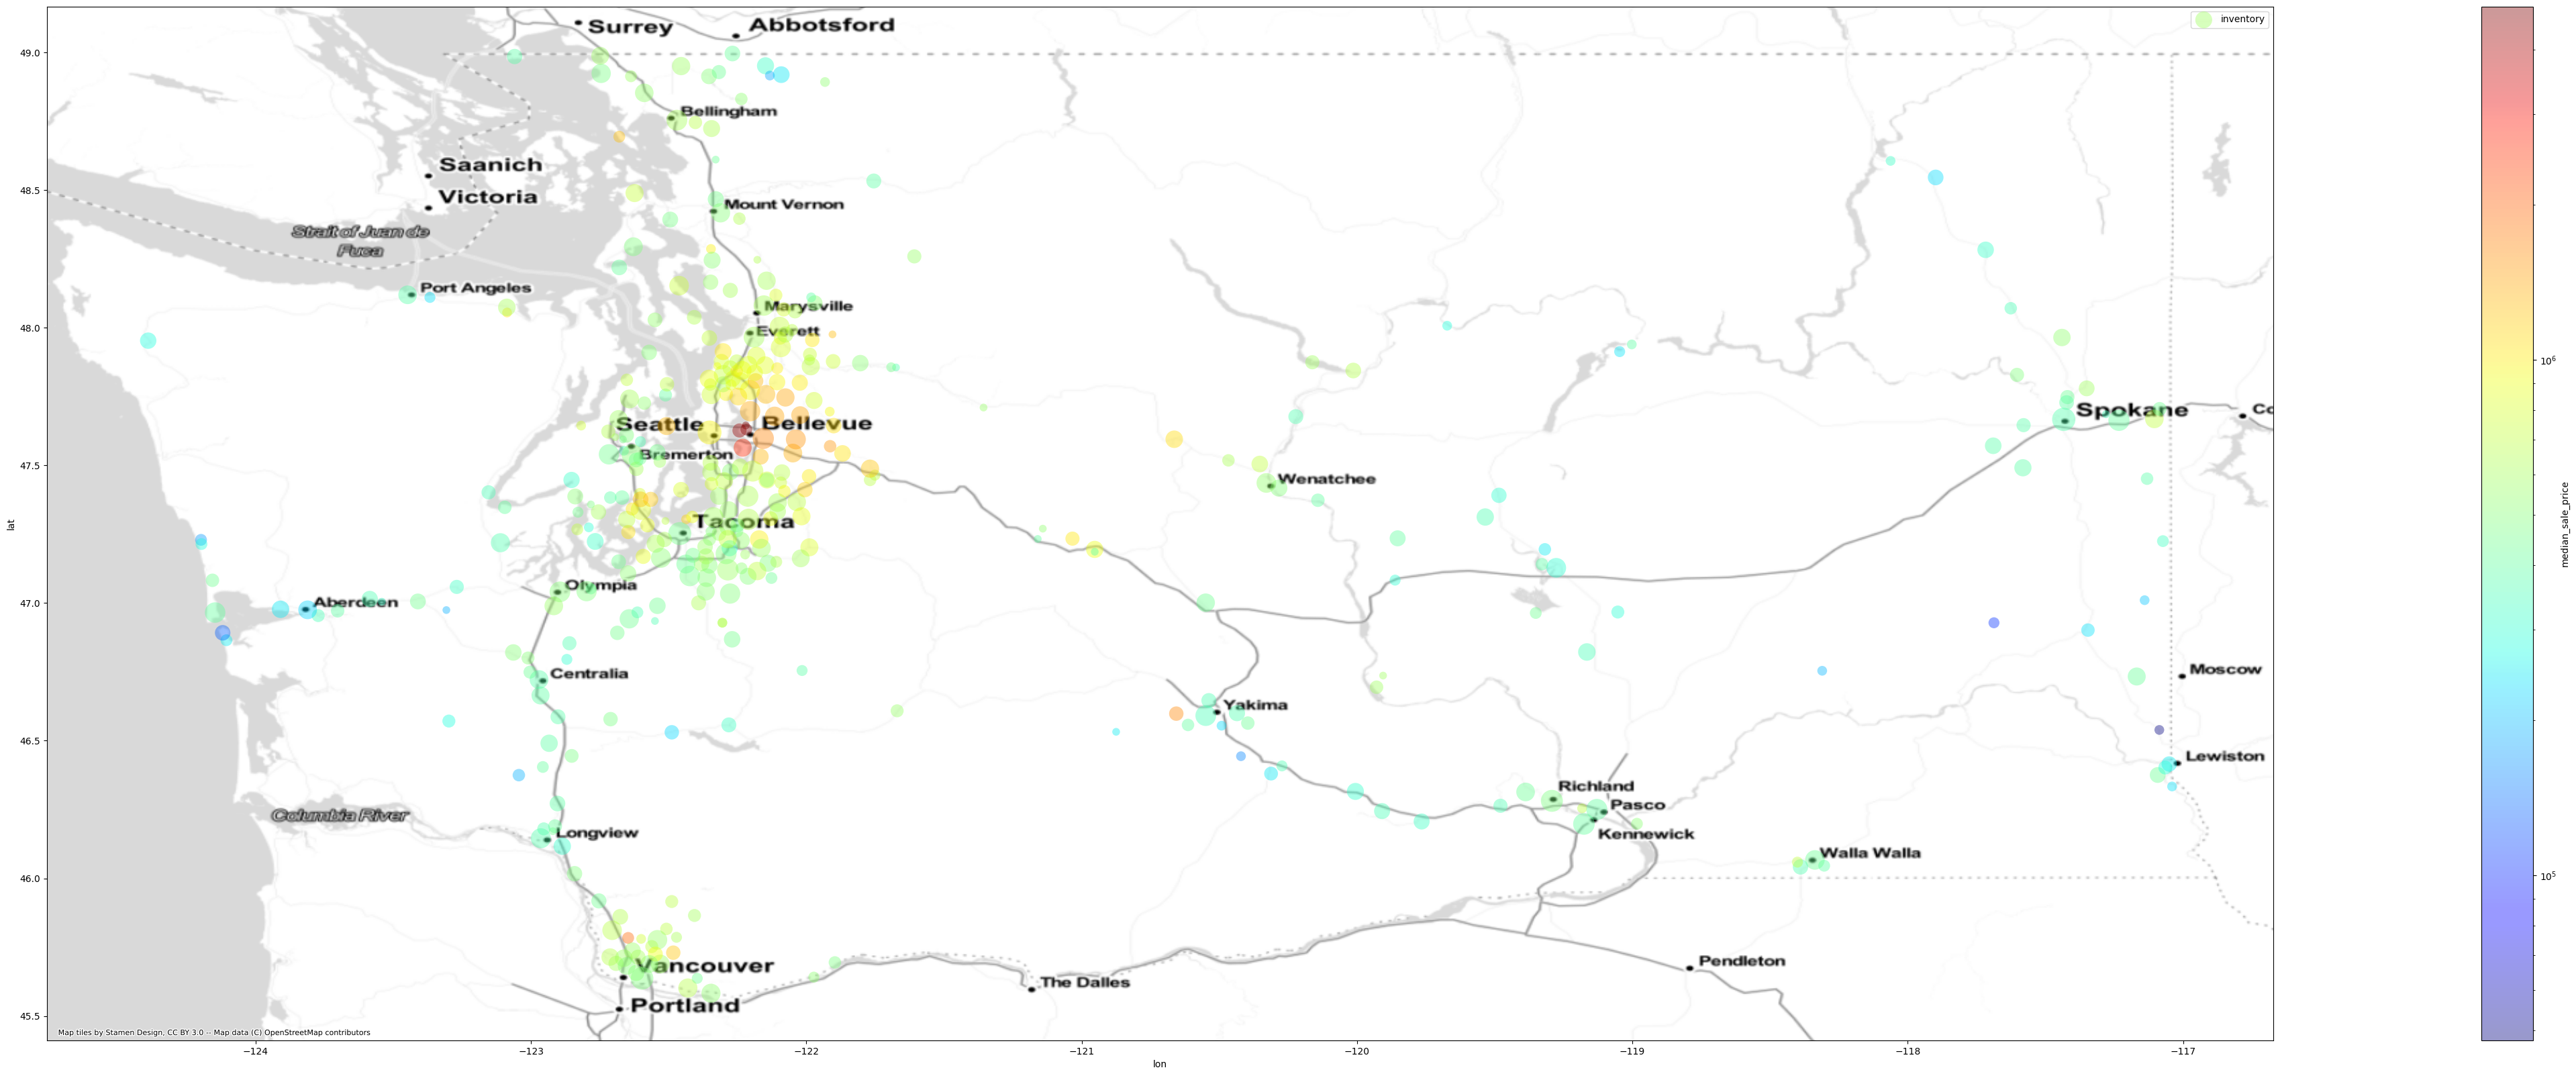

In [19]:
'''
Plot state cities on map.
'''

REGION = ["WA"]

# take only WA state
# states_map = states[states["usps_abbr"].isin(REGION)]
redfin_map = redfin[(redfin.state_abbr.isin(REGION)) & (redfin.property_type == "HOUSE")]

redfin_map = gpd.GeoDataFrame(
    redfin_map,
    geometry=gpd.points_from_xy(redfin_map.lon, redfin_map.lat),
    crs="EPSG:4269"
)

fig = plt.figure(0, figsize=(80, 20)) 
plot = fig.add_subplot()

# states_map.boundary.plot(
#     ax=plot, zorder=1,
#     linewidth=0.25, color="black",
# )

redfin_map.plot(
    ax=plot, zorder=2,
    kind="scatter", x="lon", y="lat", alpha=0.4, linewidths=0, plotnonfinite=True,
    s=np.log(redfin_map.inventory.astype("float64"))*100, label="inventory",
    c="median_sale_price", cmap="jet", colorbar=True,
    norm=colors.LogNorm(),
#     norm=colors.SymLogNorm(linthresh=0.01, vmin=-100, vmax=100, base=10),
)

cx.add_basemap(plot, crs=redfin_map.crs, source=cx.providers.Stamen.TonerLite)